# Residential Heat Pump Case Study 7 Supporting Calculations
Last Updated 09/2023  
Erik Janssen, Research Scientist  
Sustainable Technologies Evaluation Program (STEP) of Toronto and Region Conservation Authority (TRCA)

# Contents

- [1 Introduction](#1-Introduction): Introductory information  
<br>

- [2 Libraries](#2-Libraries): Import all needed libraries
<br>

- [3 Import Data](#3-Import-Data): Import electricity and gas consumption utility data gathered from bills. Import weather data. Define a function to determine heating degree days. Perform initial visualizations on the data.
<br>

- [4 Regression Analysis of Baseline Data](#4-Regression-Analysis-of-Baseline-Data): Create a baseline linear regression model of pre-retrofit gas consumption with respect to heating degree days (HDDs). Create a similar model for electricity considering HDDs and coolign degree days (CDDs). Define a function which outputs the estimated baseline kWh/day and m3/day utility consumption for a given month based on the HDDs and CDDs. 
<br>

- [5 Applying Baseline Models to Post-retrofit Conditions](#5-Applying-Baseline-Models-to-Post-retrofit-Conditions): Use the baseline models to estimate the baseline energy consumption for each month of the post-retrofit data. 
<br>

- [6 Utility Savings](#6-Utility-Savings): Determine the kWh increase and m3 decrease resulting from the retrofits.
<br>

- [7 Estimated Seasonal COP](#7-Estimated-Seasonal-COP): Check the data by making an estimate of the seasonal COP based on the electricity increase and gas decrease.
<br>

- [8 Cost Savings](#8-Cost-Savings): Based on the natural gas reductions and electricity increase, calculate net utility  cost reduction for the whole home. Since the future utility rates are uncertain, consider different scenarios.
<br>

- [9 Carbon Savings](#9-Carbon-Savings): Determine the carbon reductions.
<br>

#  1 Introduction

Back to [Contents](#Contents)

This notebook contains calculations accompanying the case study titled "Home Heat Pump Case Study 7: Air-Source Heat Pump with an Existing Furnace" available on sustainabletechnologies.ca. The calculations are used to compare the energy consumption before and after home energy retrofits were undertaken. 

To create a fair comparison pre- and post-retrofit, the pre-retrofit data was used to create a linear regression model of home energy consumption with respect to heating (and cooling) degree days. The regression models were used to develop a baseline for energy consumption against which the actual post-retrofit energy consumption could be compared (which considered differences in the heating and cooling degree days between the two periods) to determine the savings.

The retrofit measures considered in the analysis includes only the ASHP that was installed with an existing furnace.

# 2 Libraries
Back to [Contents](#Contents)

In [70]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import datetime
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import seaborn as sns
from dateutil.relativedelta import relativedelta
from matplotlib.colors import LinearSegmentedColormap

# Set some basic parameters for plotting and visualizing data
font = {'size'   : 14}
plt.rc('font', **font)
step_blue = "#00a3af"
step_gold = "#f8a81d"
pd.set_option('display.max_columns', None)
MonthFmt = mdates.DateFormatter('%m/%Y')
colors = [(0.0, step_gold), (0.5, 'white'), (1.0, step_blue)]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
%matplotlib inline
plt.style.use('default')

# 3 Import Data 
Back to [Contents](#Contents)
## 3.1 Import Electricity Data

In [71]:
# Import electricity data
ElecData1 = pd.read_csv('2020_2021.csv',parse_dates = ['Reading Date'])
ElecData2 = pd.read_csv('2021_2022.csv',parse_dates = ['Reading Date'])
ElecData3 = pd.read_csv('2022_2023.csv',parse_dates = ['Reading Date'])
ElecData = pd.concat([ElecData1,ElecData2,ElecData3])
ElecData['Total kWh'] = ElecData[' Total On-Peak kWh Consumption'] + ElecData[' Total Mid-Peak kWh Consumption'] + ElecData[' * Total Off-Peak kWh Consumption']
ElecData

,Reading Date,1 am kWh Consumption,2 am kWh Consumption,3 am kWh Consumption,4 am kWh Consumption,5 am kWh Consumption,6 am kWh Consumption,7 am kWh Consumption,8 am kWh Consumption,9 am kWh Consumption,10 am kWh Consumption,11 am kWh Consumption,12 pm kWh Consumption,1 pm kWh Consumption,2 pm kWh Consumption,3 pm kWh Consumption,4 pm kWh Consumption,5 pm kWh Consumption,6 pm kWh Consumption,7 pm kWh Consumption,8 pm kWh Consumption,9 pm kWh Consumption,10 pm kWh Consumption,11 pm kWh Consumption,12 am kWh Consumption,Total On-Peak kWh Consumption,Total Mid-Peak kWh Consumption,* Total Off-Peak kWh Consumption,Total kWh
0,2020-06-20,2.341,3.132,1.435,1.596,1.255,0.537,0.510,2.428,0.628,0.727,0.731,3.462,3.418,3.806,1.791,3.683,2.760,0.691,2.778,4.260,4.062,3.873,3.736,2.361,0.000,0.000,56.001,56.001
1,2020-06-21,1.577,2.812,0.448,2.158,0.449,0.967,2.325,0.447,0.474,0.664,0.875,2.736,3.315,3.330,3.629,0.824,1.909,1.940,1.240,3.503,3.832,3.836,0.983,1.396,0.000,0.000,45.669,45.669
2,2020-06-22,2.761,0.878,1.958,0.537,2.041,0.524,1.599,0.527,0.723,0.812,0.598,0.830,0.718,0.806,1.734,3.457,3.531,2.957,2.659,3.915,3.707,1.620,0.996,0.884,11.076,8.276,21.420,40.772
3,2020-06-23,0.657,2.375,3.128,2.627,1.465,0.460,0.463,0.466,0.477,0.940,0.534,0.866,2.749,3.457,2.343,0.887,0.700,0.886,2.358,3.724,3.780,1.826,2.029,3.028,11.002,5.661,25.562,42.225
4,2020-06-24,0.756,0.767,1.987,0.483,0.481,0.480,0.483,0.496,0.750,0.692,0.431,0.598,0.792,0.744,0.697,0.615,0.625,0.658,1.385,1.135,0.885,1.718,1.557,0.893,4.071,4.412,11.625,20.108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2023-06-16,0.699,0.614,0.566,0.543,0.563,0.590,0.932,0.535,0.862,0.692,0.728,0.941,0.835,0.571,0.536,0.566,0.531,0.537,0.688,0.934,0.839,0.798,1.127,1.097,3.980,4.042,9.302,17.324
363,2023-06-17,1.000,0.893,0.651,0.574,0.567,0.592,0.588,0.533,1.159,0.695,1.288,1.324,0.690,0.608,0.605,0.690,0.866,0.748,0.623,0.604,0.703,0.736,1.128,1.258,0.000,0.000,19.123,19.123
364,2023-06-18,0.985,0.970,0.715,0.601,0.603,0.610,0.896,0.642,0.627,0.824,1.210,0.949,0.701,0.636,0.679,0.612,0.592,0.695,0.988,1.060,1.404,1.700,2.672,2.549,0.000,0.000,23.920,23.920
365,2023-06-19,2.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.103,2.103


In [72]:
ElecData.columns

Index(['Reading Date', ' 1 am kWh Consumption', ' 2 am kWh Consumption',
       ' 3 am kWh Consumption', ' 4 am kWh Consumption',
       ' 5 am kWh Consumption', ' 6 am kWh Consumption',
       ' 7 am kWh Consumption', ' 8 am kWh Consumption',
       ' 9 am kWh Consumption', ' 10 am kWh Consumption',
       ' 11 am kWh Consumption', ' 12 pm kWh Consumption',
       ' 1 pm kWh Consumption', ' 2 pm kWh Consumption',
       ' 3 pm kWh Consumption', ' 4 pm kWh Consumption',
       ' 5 pm kWh Consumption', ' 6 pm kWh Consumption',
       ' 7 pm kWh Consumption', ' 8 pm kWh Consumption',
       ' 9 pm kWh Consumption', ' 10 pm kWh Consumption',
       ' 11 pm kWh Consumption', ' 12 am kWh Consumption',
       ' Total On-Peak kWh Consumption', ' Total Mid-Peak kWh Consumption',
       ' * Total Off-Peak kWh Consumption', 'Total kWh'],
      dtype='object')

In [73]:
# Remame some of the columns for easier referencing
ElecData.columns = ['Date', ' 1 am kWh Consumption', ' 2 am kWh Consumption',
       ' 3 am kWh Consumption', ' 4 am kWh Consumption',
       ' 5 am kWh Consumption', ' 6 am kWh Consumption',
       ' 7 am kWh Consumption', ' 8 am kWh Consumption',
       ' 9 am kWh Consumption', ' 10 am kWh Consumption',
       ' 11 am kWh Consumption', ' 12 pm kWh Consumption',
       ' 1 pm kWh Consumption', ' 2 pm kWh Consumption',
       ' 3 pm kWh Consumption', ' 4 pm kWh Consumption',
       ' 5 pm kWh Consumption', ' 6 pm kWh Consumption',
       ' 7 pm kWh Consumption', ' 8 pm kWh Consumption',
       ' 9 pm kWh Consumption', ' 10 pm kWh Consumption',
       ' 11 pm kWh Consumption', ' 12 am kWh Consumption',
       'On_Peak_kWh', 'Mid-Peak_kWh',
       'Off_Peak_kWh', 'Total_kWh']
ElecData.index = ElecData.Date

In [74]:
# Want to create a dataframe that allows me to more easily plot the hourly consumption
# First step is to simply this df a bit
ElecData_onlyhours = ElecData.iloc[:, :-4]
ElecData_onlyhours.index = ElecData_onlyhours.Date
del ElecData_onlyhours['Date']
new_column_names = np.arange(0,24,1)
ElecData_onlyhours.columns = new_column_names
ElecData_onlyhours

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Date,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-20,2.341,3.132,1.435,1.596,1.255,0.537,0.510,2.428,0.628,0.727,0.731,3.462,3.418,3.806,1.791,3.683,2.760,0.691,2.778,4.260,4.062,3.873,3.736,2.361
2020-06-21,1.577,2.812,0.448,2.158,0.449,0.967,2.325,0.447,0.474,0.664,0.875,2.736,3.315,3.330,3.629,0.824,1.909,1.940,1.240,3.503,3.832,3.836,0.983,1.396
2020-06-22,2.761,0.878,1.958,0.537,2.041,0.524,1.599,0.527,0.723,0.812,0.598,0.830,0.718,0.806,1.734,3.457,3.531,2.957,2.659,3.915,3.707,1.620,0.996,0.884
2020-06-23,0.657,2.375,3.128,2.627,1.465,0.460,0.463,0.466,0.477,0.940,0.534,0.866,2.749,3.457,2.343,0.887,0.700,0.886,2.358,3.724,3.780,1.826,2.029,3.028
2020-06-24,0.756,0.767,1.987,0.483,0.481,0.480,0.483,0.496,0.750,0.692,0.431,0.598,0.792,0.744,0.697,0.615,0.625,0.658,1.385,1.135,0.885,1.718,1.557,0.893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-16,0.699,0.614,0.566,0.543,0.563,0.590,0.932,0.535,0.862,0.692,0.728,0.941,0.835,0.571,0.536,0.566,0.531,0.537,0.688,0.934,0.839,0.798,1.127,1.097
2023-06-17,1.000,0.893,0.651,0.574,0.567,0.592,0.588,0.533,1.159,0.695,1.288,1.324,0.690,0.608,0.605,0.690,0.866,0.748,0.623,0.604,0.703,0.736,1.128,1.258
2023-06-18,0.985,0.970,0.715,0.601,0.603,0.610,0.896,0.642,0.627,0.824,1.210,0.949,0.701,0.636,0.679,0.612,0.592,0.695,0.988,1.060,1.404,1.700,2.672,2.549


In [75]:
# Now I'm going to reformat the df so it is one long column

# Reset the index temporarily
ElecData_onlyhours.reset_index(inplace=True)

# Use the melt() function to reshape the DataFrame
melted_df = pd.melt(ElecData_onlyhours, id_vars=['Date'], var_name='Hour', value_name='kWh')

# Define the values I will delete
value_to_delete1 = 'level_0'
value_to_delete2 = 'index'

# Delete rows where 'column_name' matches 'value_to_delete'
melted_df = melted_df[melted_df['Hour'] != value_to_delete1]
melted_df = melted_df[melted_df['Hour'] != value_to_delete2]

# Combine 'Date' and 'Hour' columns to create a new datetime column
melted_df['Datetime_str'] = [(str(x)[:-9] + ' ' + str(y) + ':00:00') for x,y in zip(melted_df.Date,melted_df.Hour)] 
melted_df['Datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in melted_df.Datetime_str] 

# Drop the 'Date' and 'Hour' columns if not needed anymore
melted_df.drop(columns=['Datetime_str', 'Hour', 'Date'], inplace=True)

# Set the 'Datetime' column as the index
melted_df.set_index('Datetime', inplace=True)

# Sort the index 
melted_df.sort_index(inplace=True)

# Print the resulting DataFrame
melted_df

,kWh
Datetime,
2020-06-20 00:00:00,2.341
2020-06-20 01:00:00,3.132
2020-06-20 02:00:00,1.435
2020-06-20 03:00:00,1.596
2020-06-20 04:00:00,1.255
...,...
2023-06-20 19:00:00,0.000
2023-06-20 20:00:00,0.000
2023-06-20 21:00:00,0.000


## 3.2 Visualize Electricity Data

(array([18383., 18506., 18628., 18748., 18871., 18993., 19113., 19236.,
        19358., 19478.]),
 [Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05')])

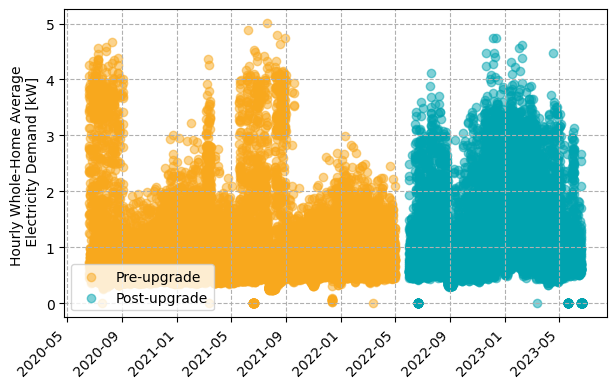

In [76]:
# Visualize hourly data
plt.figure(figsize = (7,4))
plt.style.use('default')
post_retro_elec_hourly = melted_df.loc[melted_df.index > datetime.datetime(2022,6,1)].copy()
pre_retro_elec_hourly = melted_df.loc[melted_df.index < datetime.datetime(2022,5,1)].copy()
plt.scatter(pre_retro_elec_hourly.index,pre_retro_elec_hourly.kWh, alpha = 0.5, color = step_gold, label = 'Pre-upgrade')
plt.scatter(post_retro_elec_hourly.index,post_retro_elec_hourly.kWh, alpha = 0.5, color = step_blue, label = 'Post-upgrade')
plt.grid(ls='--')
plt.ylabel('Hourly Whole-Home Average \n Electricity Demand [kW]')
plt.legend(loc = 'lower left')
plt.xticks(rotation=45, ha = 'right') 

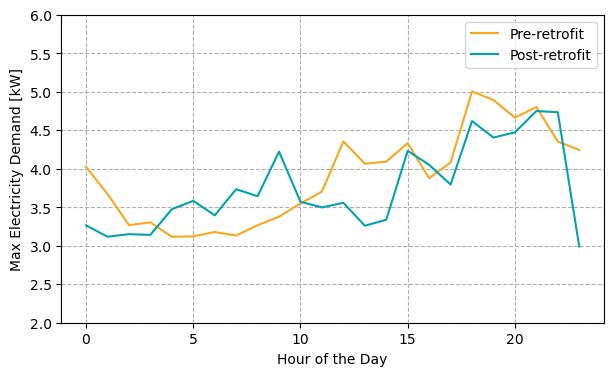

In [77]:
# Group the data by the hour and calculate the maximum electricity consumption for each hour, pre-retrofit
pre_retro_elec_hourly['Hour'] = [int(x.hour) for x in pre_retro_elec_hourly.index]
hourly_max = pre_retro_elec_hourly.groupby('Hour')['kWh'].max()
plt.figure(figsize = (7,4))
plt.style.use('default')
plt.plot(hourly_max.index, hourly_max.values, label = 'Pre-retrofit', color = step_gold)
plt.xlabel('Hour of the Day')
plt.ylabel('Max Electricity Demand [kW]')


# Group the data by the hour and calculate the maximum electricity consumption for each hour, post-retrofit
post_retro_elec_hourly['Hour'] = [int(x.hour) for x in post_retro_elec_hourly.index]
hourly_max = post_retro_elec_hourly.groupby('Hour')['kWh'].max()
plt.plot(hourly_max.index, hourly_max.values, label = 'Post-retrofit', color = step_blue)
plt.xlabel('Hour of the Day')
plt.ylabel('Max Electricity Demand [kW]')


plt.grid(ls='--')
plt.legend()
plt.ylim(2,6)
plt.show()

Pre-retrofit, the demand peaks happened mid-day and evening, and it occured during the cooling months. Post-retrofit, the peak shifted to the morning and evening. But the peak magnitude post-retrofit actually went down.

Text(0, 0.5, 'Hourly Whole-Home Electricity \n Consumption [kWh]')

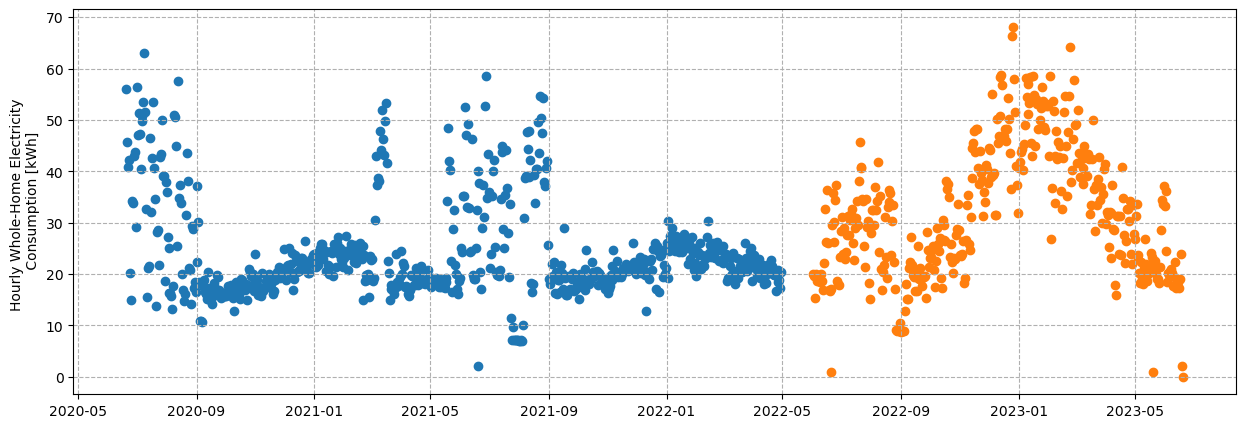

In [78]:
# Visualize daily data
plt.figure(figsize = (15,5))
post_retro_elec_hourly = ElecData.loc[ElecData.Date > datetime.datetime(2022,6,1)]
pre_retro_elec_hourly = ElecData.loc[ElecData.Date < datetime.datetime(2022,5,1)]
plt.scatter(pre_retro_elec_hourly.Date,pre_retro_elec_hourly.Total_kWh)
plt.scatter(post_retro_elec_hourly.Date,post_retro_elec_hourly.Total_kWh)
plt.grid(ls='--')
plt.ylabel('Hourly Whole-Home Electricity \n Consumption [kWh]')


Daily electricity consumption reaches a greater value post-retrofit.

C:\Users\erik.janssen\AppData\Local\Temp\ipykernel_4416\1737413417.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ElecData_monthly = ElecData.resample('m').sum()[['Total_kWh']]


Text(0, 0.5, 'Hourly Whole-Home Electricity \n Consumption [kWh]')

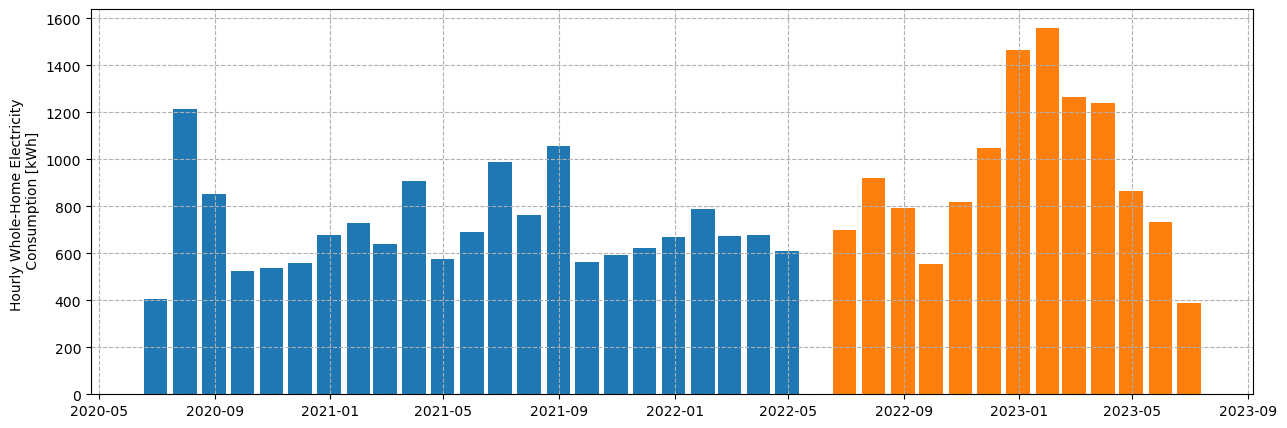

In [79]:
# Visualize monthly data
ElecData_monthly = ElecData.resample('m').sum()[['Total_kWh']]

plt.figure(figsize = (15,5))
post_retro_elec_monthly = ElecData_monthly.loc[ElecData_monthly.index > datetime.datetime(2022,6,1)]
pre_retro_elec_monthly = ElecData_monthly.loc[ElecData_monthly.index < datetime.datetime(2022,5,1)]
plt.bar(pre_retro_elec_monthly.index,pre_retro_elec_monthly.Total_kWh, width = 25)
plt.bar(post_retro_elec_monthly.index,post_retro_elec_monthly.Total_kWh, width = 25)
plt.grid(ls='--')
plt.ylabel('Hourly Whole-Home Electricity \n Consumption [kWh]')


From visual inspection, looks the summertime consumption went down and (of course) the winter time consumption went up.

## 3.3 Import Gas Data

In [80]:
# Import Pre-Retrofit Gas Data
PreRetrofit = pd.read_csv('Pre_Gas_Data3.csv',parse_dates = ['From','To'])
PreRetrofit

,From,To,Start Read,Start Read Type,End Read,End Read Type,m3,days,m3_day
0,2022-02-05,2022-04-06,13618.0,E,14076.0,A,458,60,7.633333
1,2021-12-07,2022-02-04,12954.0,E,13618.0,E,664,59,11.254237
2,2021-10-06,2021-12-07,12576.0,A,12954.0,E,378,62,6.096774
3,2021-08-05,2021-10-06,12436.0,A,12576.0,A,140,62,2.258065
4,2021-06-05,2021-08-04,12419.0,E,12436.0,A,17,60,0.283333
5,2021-04-07,2021-06-04,NaN,NaN,NaN,NaN,215,58,3.706897
6,2021-02-05,2021-04-06,NaN,NaN,NaN,NaN,575,60,9.583333
7,2020-12-04,2021-02-04,NaN,NaN,NaN,NaN,616,62,9.935484
8,2020-10-06,2020-12-03,NaN,NaN,NaN,NaN,333,58,5.741379
9,2020-08-05,2020-10-05,NaN,NaN,NaN,NaN,113,61,1.852459


Want to look at it bi-monthly because the post retrofit data needs to be looked at bi-monthly. This is because Enbridge typically estimates every other month. I can avoid issues with bad estimates post-retrofit by looking at the meter reads from actual reading to actual reading. For Pre-retrofit I didn't have the meter read for 2021-04-07 and prior, but I nonetheless wanted to include more data in the pre-retrofit model since it is bi-monthly and with fewer data points. The homeowner provided a previous gas consumption excel sheet that they had downloaded from Enbridge that had the consumption data, and this was used. Note that, Pre-retrofit, the there were more estimates. However, we know the total consumption (from the meter reads) is correct. And bi-monthly consumption based on estimates reflects the historical consumption of the home. For our purposes, that's fine.

In [81]:
# Import Post-retrofit Gas Data
PostRetrofit = pd.read_csv('Post_Gas_Data.csv',parse_dates = ['From','To'])
PostRetrofit

,From,To,Start Read,Start Read Type,End Read,End Read Type,m3,days,m3_day
0,2023-04-04,2023-06-05,15090,A,15225,A,135,62,2.177419
1,2023-02-03,2023-04-04,14875,A,15090,A,215,60,3.583333
2,2022-12-05,2023-02-03,14682,A,14875,A,193,60,3.216667
3,2022-10-06,2022-12-05,14545,A,14682,A,137,60,2.283333
4,2022-08-07,2022-10-06,14450,A,14545,A,95,60,1.583333
5,2022-06-03,2022-08-07,14332,A,14450,A,118,65,1.815385


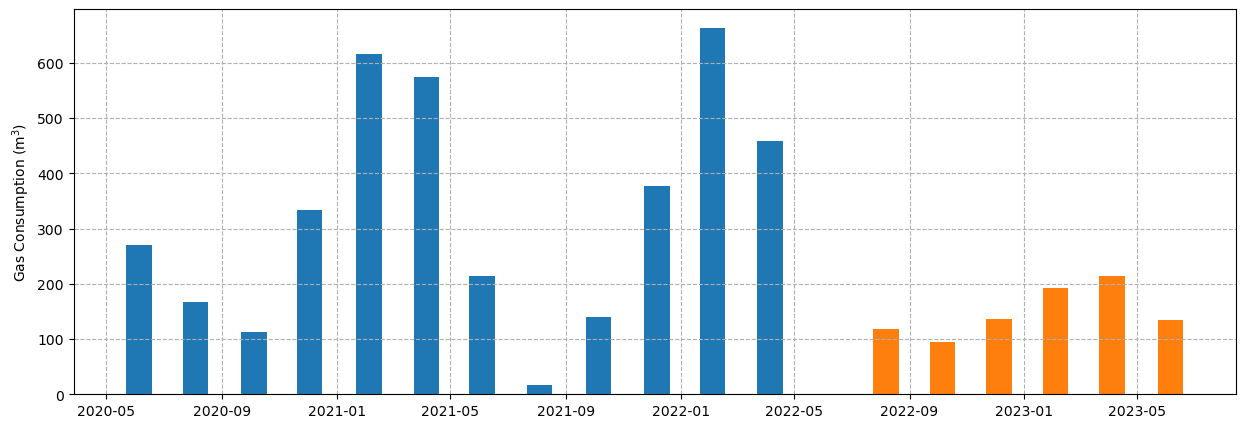

In [82]:
# Visualize gas data
# Keep in mind that it is all in 2-month periods
plt.figure(figsize = (15,5))
plt.bar(PreRetrofit.To, PreRetrofit.m3, width = 27)
plt.bar(PostRetrofit.To, PostRetrofit.m3, width = 27)
plt.ylabel('Gas Consumption (m$^{3}$)')
plt.grid(ls='--')

It's clear that drastically less gas was consumed post-retrofit.

## 3.4 Import Weather Data

In [83]:
# Import hourly weather data file for Toronto and calculate HDDs and CDDs
# Assumed building balance points to create the best linear relationships 
toronto_weather = pd.read_csv("weatherstats_toronto_hourly_10yr.csv",parse_dates=True, infer_datetime_format=True)
toronto_weather.date_time_local = [datetime.datetime.strptime(x,'%m/%d/%Y %H:%M') for x in toronto_weather.date_time_local]
toronto_weather = toronto_weather[['date_time_local','temperature']]
toronto_weather['HDDs'] = [(12 - x)*(1/24) if (x < 12) else 0 for x in toronto_weather.temperature] 
toronto_weather['CDDs'] = [(x-26)*(1/24) if (x > 26) else 0 for x in toronto_weather.temperature] 
toronto_weather.index = toronto_weather.date_time_local
del toronto_weather['date_time_local']
toronto_weather.head()

,temperature,HDDs,CDDs
date_time_local,,,
2023-05-10 12:00:00,18.4,0.000000,0.0
2023-05-10 11:00:00,17.2,0.000000,0.0
2023-05-10 10:00:00,16.8,0.000000,0.0
2023-05-10 09:00:00,14.3,0.000000,0.0
2023-05-10 08:00:00,11.3,0.029167,0.0


In [84]:
# Function that determines total HDDs in a given window of time
def HDD_total(start_date,end_date):
    temp_df = toronto_weather.loc[(toronto_weather.index>=start_date)&(toronto_weather.index<(end_date + datetime.timedelta(days=1)))]
    total_HDDs = temp_df.HDDs.sum()
    total_CDDs = temp_df.CDDs.sum()
    return {'HDDs':total_HDDs,
            'CDDs':total_CDDs}

## 3.5 More Visualizations with Respect to HDDs and CDDs

In [85]:
# Function to add some more needed columsn onto the dfs
def columns_add(x):
    x['HDDs'] = [HDD_total(strt,end)['HDDs'] for strt,end in zip(x.From,x.To)]
    x['HDDs_day'] = x.HDDs/x.days
    x['CDDs'] = [HDD_total(strt,end)['CDDs'] for strt,end in zip(x.From,x.To)]
    x['CDDs_day'] = x.CDDs/x.days
# Add additional columns to PreRetrofit df for gas
columns_add(PreRetrofit)
PreRetrofit

,From,To,Start Read,Start Read Type,End Read,End Read Type,m3,days,m3_day,HDDs,HDDs_day,CDDs,CDDs_day
0,2022-02-05,2022-04-06,13618.0,E,14076.0,A,458,60,7.633333,773.095833,12.884931,0.000000,0.000000
1,2021-12-07,2022-02-04,12954.0,E,13618.0,E,664,59,11.254237,944.216667,16.003672,0.000000,0.000000
2,2021-10-06,2021-12-07,12576.0,A,12954.0,E,378,62,6.096774,353.850000,5.707258,0.000000,0.000000
3,2021-08-05,2021-10-06,12436.0,A,12576.0,A,140,62,2.258065,4.316667,0.069624,19.808333,0.319489
4,2021-06-05,2021-08-04,12419.0,E,12436.0,A,17,60,0.283333,0.962500,0.016042,22.516667,0.375278
5,2021-04-07,2021-06-04,NaN,NaN,NaN,NaN,215,58,3.706897,154.129167,2.657399,4.158333,0.071695
6,2021-02-05,2021-04-06,NaN,NaN,NaN,NaN,575,60,9.583333,741.041667,12.350694,0.000000,0.000000
7,2020-12-04,2021-02-04,NaN,NaN,NaN,NaN,616,62,9.935484,855.554167,13.799261,0.000000,0.000000
8,2020-10-06,2020-12-03,NaN,NaN,NaN,NaN,333,58,5.741379,304.770833,5.254670,0.000000,0.000000
9,2020-08-05,2020-10-05,NaN,NaN,NaN,NaN,113,61,1.852459,21.900000,0.359016,13.091667,0.214617


In [86]:
# Add additional columns to PostRetrofit df for gas
columns_add(PostRetrofit)
PostRetrofit

,From,To,Start Read,Start Read Type,End Read,End Read Type,m3,days,m3_day,HDDs,HDDs_day,CDDs,CDDs_day
0,2023-04-04,2023-06-05,15090,A,15225,A,135,62,2.177419,144.054167,2.323454,0.708333,0.011425
1,2023-02-03,2023-04-04,14875,A,15090,A,215,60,3.583333,709.729167,11.828819,0.000000,0.000000
2,2022-12-05,2023-02-03,14682,A,14875,A,193,60,3.216667,797.054167,13.284236,0.000000,0.000000
3,2022-10-06,2022-12-05,14545,A,14682,A,137,60,2.283333,349.770833,5.829514,0.000000,0.000000
4,2022-08-07,2022-10-06,14450,A,14545,A,95,60,1.583333,15.662500,0.261042,9.116667,0.151944
5,2022-06-03,2022-08-07,14332,A,14450,A,118,65,1.815385,1.741667,0.026795,34.341667,0.528333


In [87]:
# Prep monthly elec df
ElecData_monthly['beginning_of_month'] = ElecData_monthly.index - pd.offsets.MonthEnd() +datetime.timedelta(days=1)
ElecData_monthly['days'] = [((x-y).days + 1) for x,y in zip(ElecData_monthly.index,ElecData_monthly.beginning_of_month)]
ElecData_monthly['HDDs'] = [HDD_total(strt,end)['HDDs'] for strt,end in zip(ElecData_monthly.beginning_of_month,ElecData_monthly.index)]
ElecData_monthly['HDDs_day'] = ElecData_monthly.HDDs/ElecData_monthly.days
ElecData_monthly['CDDs'] = [HDD_total(strt,end)['CDDs'] for strt,end in zip(ElecData_monthly.beginning_of_month,ElecData_monthly.index)]
ElecData_monthly['CDDs_day'] =ElecData_monthly.CDDs/ElecData_monthly.days
ElecData_monthly['kWh_day'] = ElecData_monthly.Total_kWh/ElecData_monthly.days 
ElecData_monthly

,Total_kWh,beginning_of_month,days,HDDs,HDDs_day,CDDs,CDDs_day,kWh_day
Date,,,,,,,,
2020-06-30,403.74400,2020-06-01,30,3.179167,0.105972,12.250000,0.408333,13.458133
2020-07-31,1214.60800,2020-07-01,31,0.000000,0.000000,37.208333,1.200269,39.180903
2020-08-31,850.57900,2020-08-01,31,0.012500,0.000403,13.275000,0.428226,27.438032
2020-09-30,525.75000,2020-09-01,30,11.029167,0.367639,0.708333,0.023611,17.525000
2020-10-31,536.30900,2020-10-01,31,104.454167,3.369489,0.000000,0.000000,17.300290
2020-11-30,559.89400,2020-11-01,30,176.508333,5.883611,0.000000,0.000000,18.663133
2020-12-31,680.05200,2020-12-01,31,380.058333,12.259946,0.000000,0.000000,21.937161
2021-01-31,727.10400,2021-01-01,31,445.108333,14.358333,0.000000,0.000000,23.454968
2021-02-28,638.36800,2021-02-01,28,479.412500,17.121875,0.000000,0.000000,22.798857


In [88]:
ElecData_monthly_pre = ElecData_monthly.loc[ElecData_monthly.index < datetime.datetime(2022,5,1)].copy()
ElecData_monthly_pre = ElecData_monthly_pre.loc[ElecData_monthly_pre.index > datetime.datetime(2021,3,31)].copy()
ElecData_monthly_pre_heat = ElecData_monthly_pre.loc[(ElecData_monthly_pre.HDDs > 1)&(ElecData_monthly_pre.CDDs == 0)].copy()
ElecData_monthly_pre_cool = ElecData_monthly_pre.loc[(ElecData_monthly_pre.CDDs > 0)&(ElecData_monthly_pre.HDDs < 10)].copy()
ElecData_monthly_post = ElecData_monthly.loc[ElecData_monthly.index > datetime.datetime(2022,6,1)].copy()
ElecData_monthly_post_heat = ElecData_monthly_post.loc[(ElecData_monthly_post.HDDs > 1)&(ElecData_monthly_post.CDDs == 0)].copy()
ElecData_monthly_post_cool = ElecData_monthly_post.loc[(ElecData_monthly_post.CDDs > 0)&(ElecData_monthly_post.HDDs < 10)].copy()

Text(0, 0.5, 'Monthly Elec Consumption [kWh]')

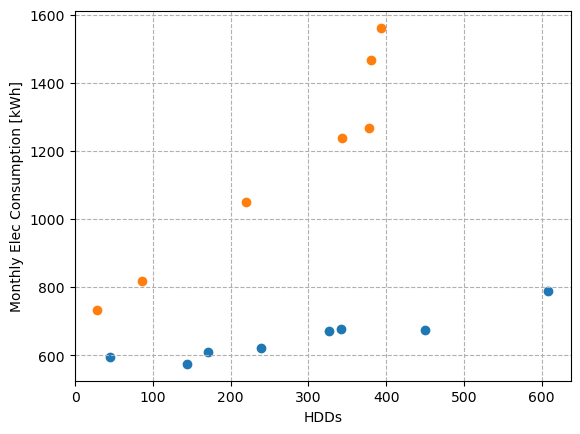

In [89]:
# Visualize pre and post elec consumption w.r.t HDDs
plt.scatter(ElecData_monthly_pre_heat.HDDs,ElecData_monthly_pre_heat.Total_kWh, label = 'Pre-Retrofit')
plt.scatter(ElecData_monthly_post_heat.HDDs,ElecData_monthly_post_heat.Total_kWh, label = 'Post-Retrofit')
plt.grid(ls='--')
plt.xlabel('HDDs')
plt.ylabel('Monthly Elec Consumption [kWh]')

Text(0, 0.5, 'Whole-home Electricity \n Consyumption [kWh]')

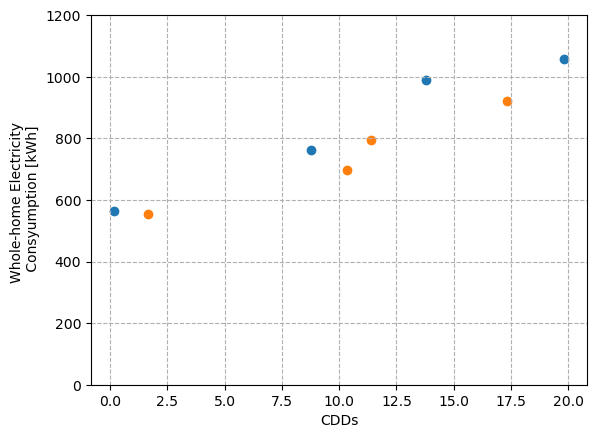

In [90]:
# Visualize pre- and post- elec consumption with respect to CDDs
plt.scatter(ElecData_monthly_pre_cool.CDDs,ElecData_monthly_pre_cool.Total_kWh, label = 'Pre-retrofit')
plt.scatter(ElecData_monthly_post_cool.CDDs,ElecData_monthly_post_cool.Total_kWh, label = 'Post-retrofit')
plt.grid(ls='--')
plt.ylim(0,1200)
plt.xlabel('CDDs')
plt.ylabel('Whole-home Electricity \n Consyumption [kWh]')

Looks like the cooling electricity did decrease after accounting for changes in weather.

# 4 Regression Analysis of Baseline Data
Back to [Contents](#Contents)
## 4.1 Gas Baseline

coefficient of determination (R2): 0.9391332266733159
intercept: 2.0085846881595435
slope: [0.56569925]


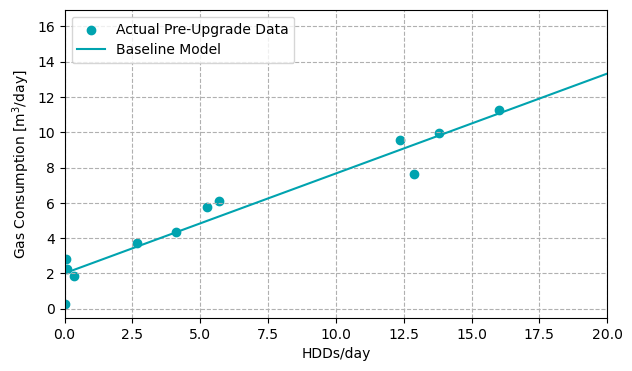

In [91]:
# Calculate regression line for baseline gas data
x = np.array(PreRetrofit.HDDs_day).reshape((-1, 1))
y = np.array(PreRetrofit.m3_day)
base_model_gas = LinearRegression()
base_model_gas.fit(x, y)
base_model_gas_r_sq = base_model_gas.score(x, y)
print('coefficient of determination (R2):', base_model_gas_r_sq)
print('intercept:', base_model_gas.intercept_)
print('slope:', base_model_gas.coef_)

# Function for baseline model
def baseline_gas(HDDs_day):
    m3_day = base_model_gas.coef_[0]*HDDs_day + base_model_gas.intercept_
    return m3_day

# Visualize pre-retrofit data, baseline model, and post-retrofit data
x = [0,25]
y = [baseline_gas(a) for a in x]
plt.figure(figsize = (7,4))
plt.style.use('default')
plt.scatter(PreRetrofit.HDDs_day,PreRetrofit.m3_day, color = step_blue, label = 'Actual Pre-Upgrade Data')
plt.plot(x,y, color = step_blue, label = 'Baseline Model')
#plt.scatter(temp_df.HDDs_day,temp_df.m3_day, color = 'red')
plt.xlim(0,20)
plt.xlabel('HDDs/day')
plt.ylabel('Gas Consumption [m$^{3}$/day]')
plt.grid(ls='--')
plt.legend(loc = 2)

In [92]:
# Add the modelled baseline data to the pre-retrofit utility dataframe
PreRetrofit['modelled_m3_day'] = [baseline_gas(m3_day) for m3_day in PreRetrofit.HDDs_day]
PreRetrofit

,From,To,Start Read,Start Read Type,End Read,End Read Type,m3,days,m3_day,HDDs,HDDs_day,CDDs,CDDs_day,modelled_m3_day
0,2022-02-05,2022-04-06,13618.0,E,14076.0,A,458,60,7.633333,773.095833,12.884931,0.000000,0.000000,9.297580
1,2021-12-07,2022-02-04,12954.0,E,13618.0,E,664,59,11.254237,944.216667,16.003672,0.000000,0.000000,11.061850
2,2021-10-06,2021-12-07,12576.0,A,12954.0,E,378,62,6.096774,353.850000,5.707258,0.000000,0.000000,5.237176
3,2021-08-05,2021-10-06,12436.0,A,12576.0,A,140,62,2.258065,4.316667,0.069624,19.808333,0.319489,2.047971
4,2021-06-05,2021-08-04,12419.0,E,12436.0,A,17,60,0.283333,0.962500,0.016042,22.516667,0.375278,2.017659
5,2021-04-07,2021-06-04,NaN,NaN,NaN,NaN,215,58,3.706897,154.129167,2.657399,4.158333,0.071695,3.511874
6,2021-02-05,2021-04-06,NaN,NaN,NaN,NaN,575,60,9.583333,741.041667,12.350694,0.000000,0.000000,8.995363
7,2020-12-04,2021-02-04,NaN,NaN,NaN,NaN,616,62,9.935484,855.554167,13.799261,0.000000,0.000000,9.814816
8,2020-10-06,2020-12-03,NaN,NaN,NaN,NaN,333,58,5.741379,304.770833,5.254670,0.000000,0.000000,4.981147
9,2020-08-05,2020-10-05,NaN,NaN,NaN,NaN,113,61,1.852459,21.900000,0.359016,13.091667,0.214617,2.211680


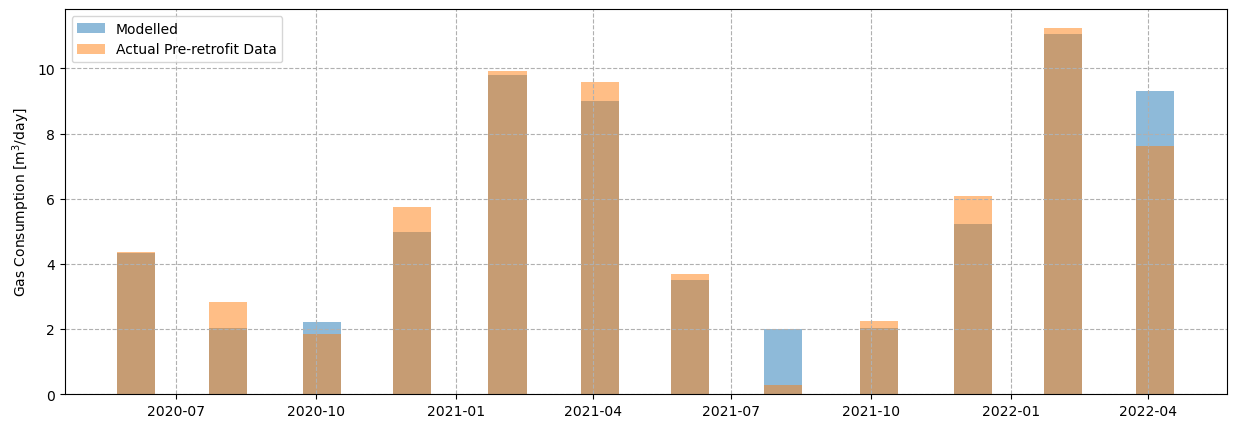

In [93]:
#Visualize model vs. actual for the pre-retrofit data - to help see how good it is
plt.figure(figsize = (15,5))
plt.bar(PreRetrofit.To,PreRetrofit.modelled_m3_day, alpha =0.5,width = 25, label = 'Modelled')
plt.bar(PreRetrofit.To,PreRetrofit.m3_day, alpha = 0.5, width = 25, label = 'Actual Pre-retrofit Data')
plt.grid(ls='--')
plt.ylabel('Gas Consumption [m$^{3}$/day]')
plt.legend()


Gas baseline model looks good.

## 4.2 Electricity Baseline

coefficient of determination (R2): 0.9442387781868508
intercept: 18.590924679115332
slope: [26.0344042]


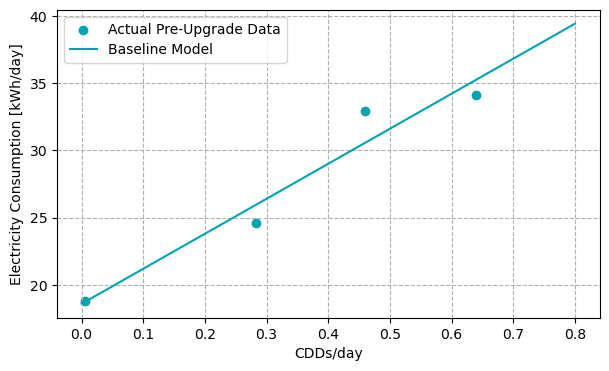

In [94]:
# Find correlations with CDDs
# Cooling df
PreRetrofitCool = ElecData_monthly_pre_cool

# Calculate regression line for baseline data
x = np.array(PreRetrofitCool.CDDs_day).reshape((-1, 1))
y = np.array(PreRetrofitCool.kWh_day)
base_model_ElecCool = LinearRegression()
base_model_ElecCool.fit(x, y)
base_model_ElecCool_r_sq = base_model_ElecCool.score(x, y)
print('coefficient of determination (R2):', base_model_ElecCool_r_sq)
print('intercept:', base_model_ElecCool.intercept_)
print('slope:', base_model_ElecCool.coef_)

# Function for baseline model
def baseline_ElecCool(CDDs_day):
    kWh_day = base_model_ElecCool.coef_[0]*CDDs_day + base_model_ElecCool.intercept_
    return kWh_day

# Visualize pre-retrofit data, baseline model, and post-retrofit data
x = [0,0.8]
y = [baseline_ElecCool(a) for a in x]
plt.figure(figsize = (7,4))
plt.style.use('default')
plt.scatter(PreRetrofitCool.CDDs_day,PreRetrofitCool.kWh_day, color = step_blue, label = 'Actual Pre-Upgrade Data')
#plt.scatter(ElecData_monthly_post_cool.CDDs_day,ElecData_monthly_post_cool.kWh_day,  label = 'Actual Pre-Upgrade Data',color = step_gold)
plt.plot(x,y, color = step_blue, label = 'Baseline Model')
#plt.xlim(0,1)
#plt.ylim(15,35)
plt.xlabel('CDDs/day')
plt.ylabel('Electricity Consumption [kWh/day]')
plt.grid(ls='--')
plt.legend(loc = 2)

coefficient of determination (R2): 0.9699213215931425
intercept: 17.981313843045665
slope: [0.36973471]


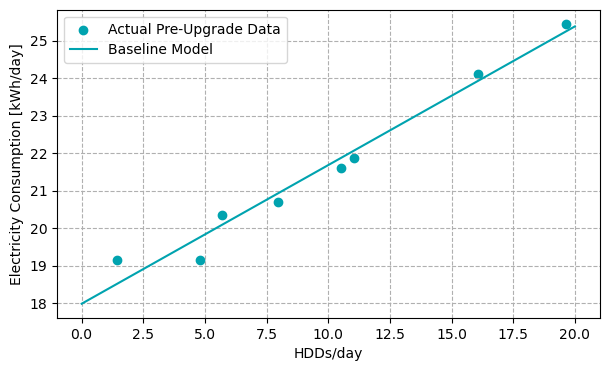

In [95]:
# Find correlations with HDDs
# Heat df
PreRetrofitHeat = ElecData_monthly_pre_heat

# Calculate regression line for baseline data
x = np.array(PreRetrofitHeat.HDDs_day).reshape((-1, 1))
y = np.array(PreRetrofitHeat.kWh_day)
base_model_ElecHeat = LinearRegression()
base_model_ElecHeat.fit(x, y)
base_model_ElecHeat_r_sq = base_model_ElecHeat.score(x, y)
print('coefficient of determination (R2):', base_model_ElecHeat_r_sq)
print('intercept:', base_model_ElecHeat.intercept_)
print('slope:', base_model_ElecHeat.coef_)

# Function for baseline model
def baseline_ElecHeat(HDDs_day):
    kWh_day = base_model_ElecHeat.coef_[0]*HDDs_day + base_model_ElecHeat.intercept_
    return kWh_day


# Visualize pre-retrofit data, baseline model, and post-retrofit data
x = [0,20]
y = [baseline_ElecHeat(a) for a in x]
plt.figure(figsize = (7,4))
plt.style.use('default')
plt.scatter(PreRetrofitHeat.HDDs_day,PreRetrofitHeat.kWh_day, color = step_blue, label = 'Actual Pre-Upgrade Data')
plt.plot(x,y, color = step_blue, label = 'Baseline Model')
#plt.xlim(0,20)
#plt.ylim(10,35)
plt.xlabel('HDDs/day')
plt.ylabel('Electricity Consumption [kWh/day]')
plt.grid(ls='--')
plt.legend(loc = 2)


In [96]:
# Function to choose whether to use HDDs or CDD model for baseline electricity
def baselineElec(CDDs_day,HDDs_day):
    kWh_day = 'null'
    if CDDs_day > 0.1:
        kWh_day = baseline_ElecCool(CDDs_day)
    else:
        kWh_day = baseline_ElecHeat(HDDs_day)
    return kWh_day       


In [97]:
# Add to preretrofit df
ElecData_monthly_pre['modelled_kWh_day'] = [baselineElec(x,y) for x,y in zip(ElecData_monthly_pre.CDDs_day,ElecData_monthly_pre.HDDs_day)]
ElecData_monthly_pre['kWh_day'] = ElecData_monthly_pre.Total_kWh/ElecData_monthly_pre.days
ElecData_monthly_pre

,Total_kWh,beginning_of_month,days,HDDs,HDDs_day,CDDs,CDDs_day,kWh_day,modelled_kWh_day
Date,,,,,,,,,
2021-04-30,574.33400,2021-04-01,30,144.212500,4.807083,0.000000,0.000000,19.144467,19.758659
2021-05-31,689.44200,2021-05-01,31,56.679167,1.828360,3.958333,0.127688,22.240065,21.915210
2021-06-30,987.89300,2021-06-01,30,0.912500,0.030417,13.775000,0.459167,32.929767,30.545055
2021-07-31,762.59600,2021-07-01,31,0.050000,0.001613,8.766667,0.282796,24.599871,25.953342
2021-08-31,1057.90500,2021-08-01,31,0.000000,0.000000,19.825000,0.639516,34.125968,35.240346
2021-09-30,564.34400,2021-09-01,30,3.225000,0.107500,0.158333,0.005278,18.811467,18.021060
2021-10-31,593.32600,2021-10-01,31,44.800000,1.445161,0.000000,0.000000,19.139548,18.515640
2021-11-30,621.11500,2021-11-01,30,238.616667,7.953889,0.000000,0.000000,20.703833,20.922143
2021-12-31,669.94801,2021-12-01,31,326.329167,10.526747,0.000000,0.000000,21.611226,21.873418


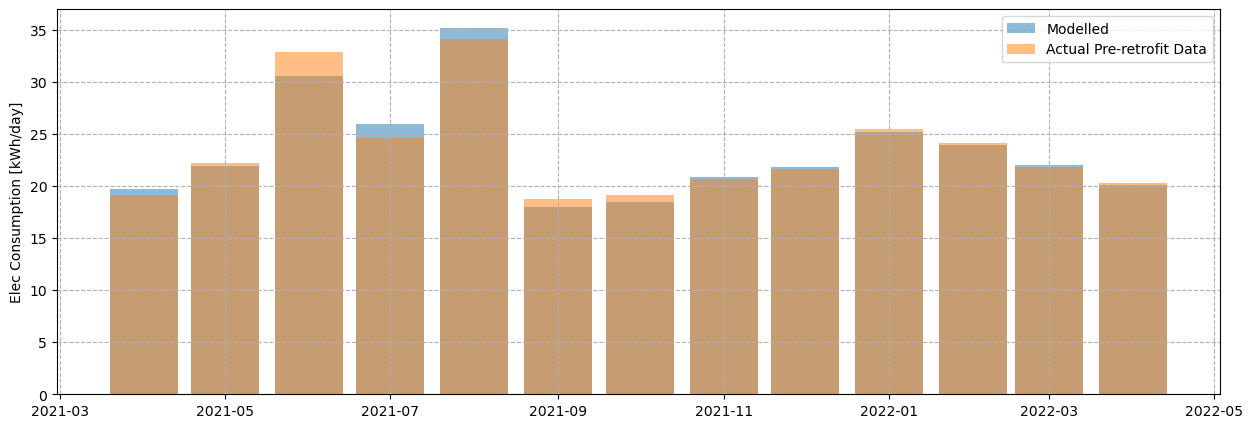

In [98]:
#Visualize model vs. actual pre-retrofit
plt.figure(figsize = (15,5))
plt.bar(ElecData_monthly_pre.beginning_of_month,ElecData_monthly_pre.modelled_kWh_day, alpha =0.5,width = 25, label = 'Modelled')
plt.bar(ElecData_monthly_pre.beginning_of_month,ElecData_monthly_pre.kWh_day, alpha = 0.5, width = 25, label = 'Actual Pre-retrofit Data')
plt.grid(ls='--')
plt.ylabel('Elec Consumption [kWh/day]')
plt.legend()


The elec models are a very good predictor of electricity consumption.

# 5 Applying Baseline Models to Post-retrofit Conditions
Back to [Contents](#Contents)

In [99]:
# Add some parameters to the post-retrofit gas dataframe
PostRetrofit['modelled_m3_day'] = [baseline_gas(x) for x in PostRetrofit.HDDs_day]
PostRetrofit['modelled_m3'] = PostRetrofit.modelled_m3_day * PostRetrofit.days
PostRetrofit['start_month'] = [x.strftime('%b') for x in PostRetrofit.From]
PostRetrofit['end_month'] = [(x + relativedelta(months=1)).strftime('%b') for x in PostRetrofit.From]# not actual end month - this is just to make simpler plot...

# Sort the DataFrame by the 'Date' column in descending order (latest to earliest)
PostRetrofit = PostRetrofit.sort_values(by='From', ascending=True)

# Reset the index
PostRetrofit = PostRetrofit.reset_index(drop=True)

PostRetrofit


,From,To,Start Read,Start Read Type,End Read,End Read Type,m3,days,m3_day,HDDs,HDDs_day,CDDs,CDDs_day,modelled_m3_day,modelled_m3,start_month,end_month
0,2022-06-03,2022-08-07,14332,A,14450,A,118,65,1.815385,1.741667,0.026795,34.341667,0.528333,2.023743,131.543264,Jun,Jul
1,2022-08-07,2022-10-06,14450,A,14545,A,95,60,1.583333,15.662500,0.261042,9.116667,0.151944,2.156256,129.375346,Aug,Sep
2,2022-10-06,2022-12-05,14545,A,14682,A,137,60,2.283333,349.770833,5.829514,0.000000,0.000000,5.306336,318.380179,Oct,Nov
3,2022-12-05,2023-02-03,14682,A,14875,A,193,60,3.216667,797.054167,13.284236,0.000000,0.000000,9.523467,571.408024,Dec,Jan
4,2023-02-03,2023-04-04,14875,A,15090,A,215,60,3.583333,709.729167,11.828819,0.000000,0.000000,8.700139,522.008338,Feb,Mar
5,2023-04-04,2023-06-05,15090,A,15225,A,135,62,2.177419,144.054167,2.323454,0.708333,0.011425,3.322961,206.023585,Apr,May


In [100]:
# Going to want to change the labels
x_axis_labels = []
for x,y in zip(PostRetrofit.start_month,PostRetrofit.end_month):
    x_axis_labels.append(x + '/' + y)
x_axis_labels

['Jun/Jul', 'Aug/Sep', 'Oct/Nov', 'Dec/Jan', 'Feb/Mar', 'Apr/May']

([<matplotlib.axis.XTick at 0x295cae9e010>,
 [Text(0, 0, 'Jun/Jul'),
  Text(1, 0, 'Aug/Sep'),
  Text(2, 0, 'Oct/Nov'),
  Text(3, 0, 'Dec/Jan'),
  Text(4, 0, 'Feb/Mar'),
  Text(5, 0, 'Apr/May')])

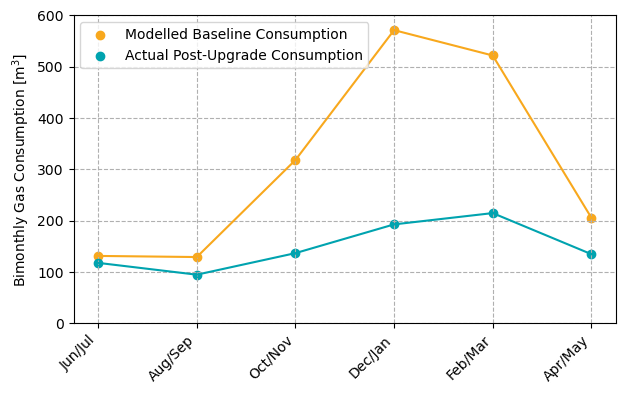

In [101]:
#Visualize modelled baseline vs. actual post-retrofit
plt.figure(figsize = (7,4))
plt.style.use('default')
plt.plot(PostRetrofit.index,PostRetrofit.modelled_m3, color = step_gold)
plt.scatter(PostRetrofit.index,PostRetrofit.modelled_m3, label = 'Modelled Baseline Consumption', color = step_gold)
plt.plot(PostRetrofit.index,PostRetrofit.m3, color = step_blue)
plt.scatter(PostRetrofit.index,PostRetrofit.m3, label = 'Actual Post-Upgrade Consumption', color = step_blue)
plt.grid(ls='--')
plt.ylabel('Bimonthly Gas Consumption [m$^{3}$]')
plt.legend(loc = 'upper left')
plt.ylim(0,600)
#lt.ylabel('Monthly Gas Consumption [m$^{3}$]')
plt.xticks(PostRetrofit.index, labels = x_axis_labels, rotation=45, ha = 'right')  # Adjust the angle as needed

In [102]:
# Going to still to determine elec savings monthly, but spanning the same period as the gas data
# Detemine monthly periods that span same length as gas bill data

Elec_From = pd.Series([datetime.datetime(2022,6,3),
            datetime.datetime(2022,7,3),
            datetime.datetime(2022,8,7),
            datetime.datetime(2022,9,7),
            datetime.datetime(2022,10,6),
            datetime.datetime(2022,11,6),
            datetime.datetime(2022,12,5),
            datetime.datetime(2023,1,5),
            datetime.datetime(2023,2,3),
            datetime.datetime(2023,3,3),
            datetime.datetime(2023,4,4),
            datetime.datetime(2023,5,4),          
            datetime.datetime(2023,6,5)]) 

Elec_To = [x - relativedelta(days = 1) for x in Elec_From[1:]]
Elec_From = Elec_From[:-1]

PostRetrofitElec = pd.DataFrame({
    'From': Elec_From,
    'To': Elec_To
})
PostRetrofitElec

,From,To
0,2022-06-03,2022-07-02
1,2022-07-03,2022-08-06
2,2022-08-07,2022-09-06
3,2022-09-07,2022-10-05
4,2022-10-06,2022-11-05
5,2022-11-06,2022-12-04
6,2022-12-05,2023-01-04
7,2023-01-05,2023-02-02
8,2023-02-03,2023-03-02
9,2023-03-03,2023-04-03


In [103]:
# Add actual elec consumption
PostRetrofitElec['kWh'] = [ElecData.loc[(ElecData.index >= x)&(ElecData.index <= y)].Total_kWh.sum() for x,y in zip(PostRetrofitElec.From,PostRetrofitElec.To)]
PostRetrofitElec

,From,To,kWh
0,2022-06-03,2022-07-02,711.570
1,2022-07-03,2022-08-06,1053.751
2,2022-08-07,2022-09-06,668.389
3,2022-09-07,2022-10-05,604.142
4,2022-10-06,2022-11-05,815.474
5,2022-11-06,2022-12-04,1117.093
6,2022-12-05,2023-01-04,1454.805
7,2023-01-05,2023-02-02,1491.678
8,2023-02-03,2023-03-02,1255.837
9,2023-03-03,2023-04-03,1241.467


In [104]:
# Add days, HDDs, etc.
PostRetrofitElec['days'] = [((x-y).days + 1) for x,y in zip(PostRetrofitElec.To,PostRetrofitElec.From)]
PostRetrofitElec['HDDs'] = [HDD_total(strt,end)['HDDs'] for strt,end in zip(PostRetrofitElec.From,PostRetrofitElec.To)]
PostRetrofitElec['HDDs_day'] = PostRetrofitElec.HDDs/PostRetrofitElec.days
PostRetrofitElec['CDDs'] = [HDD_total(strt,end)['CDDs'] for strt,end in zip(PostRetrofitElec.From,PostRetrofitElec.To)]
PostRetrofitElec['CDDs_day'] = PostRetrofitElec.CDDs/PostRetrofitElec.days
PostRetrofitElec

,From,To,kWh,days,HDDs,HDDs_day,CDDs,CDDs_day
0,2022-06-03,2022-07-02,711.570,30,1.741667,0.058056,11.375000,0.379167
1,2022-07-03,2022-08-06,1053.751,35,0.000000,0.000000,20.208333,0.577381
2,2022-08-07,2022-09-06,668.389,31,0.000000,0.000000,8.554167,0.275941
3,2022-09-07,2022-10-05,604.142,29,15.662500,0.540086,0.562500,0.019397
4,2022-10-06,2022-11-05,815.474,31,87.187500,2.812500,0.000000,0.000000
5,2022-11-06,2022-12-04,1117.093,29,253.279167,8.733764,0.000000,0.000000
6,2022-12-05,2023-01-04,1454.805,31,374.075000,12.066935,0.000000,0.000000
7,2023-01-05,2023-02-02,1491.678,29,394.683333,13.609770,0.000000,0.000000
8,2023-02-03,2023-03-02,1255.837,28,363.008333,12.964583,0.000000,0.000000
9,2023-03-03,2023-04-03,1241.467,32,343.170833,10.724089,0.000000,0.000000


In [105]:
# Apply baseline model
PostRetrofitElec['modelled_kWh_day'] = [baselineElec(x,y) for x,y in zip(PostRetrofitElec.CDDs_day,PostRetrofitElec.HDDs_day)]
PostRetrofitElec['modelled_kWh'] = PostRetrofitElec.modelled_kWh_day * PostRetrofitElec.days
PostRetrofitElec['month_'] = [x.strftime('%b') for x in PostRetrofitElec.From]
PostRetrofitElec

,From,To,kWh,days,HDDs,HDDs_day,CDDs,CDDs_day,modelled_kWh_day,modelled_kWh,month_
0,2022-06-03,2022-07-02,711.570,30,1.741667,0.058056,11.375000,0.379167,28.462303,853.869088,Jun
1,2022-07-03,2022-08-06,1053.751,35,0.000000,0.000000,20.208333,0.577381,33.622694,1176.794282,Jul
2,2022-08-07,2022-09-06,668.389,31,0.000000,0.000000,8.554167,0.275941,25.774881,799.021298,Aug
3,2022-09-07,2022-10-05,604.142,29,15.662500,0.540086,0.562500,0.019397,18.181002,527.249071,Sep
4,2022-10-06,2022-11-05,815.474,31,87.187500,2.812500,0.000000,0.000000,19.021193,589.656974,Oct
5,2022-11-06,2022-12-04,1117.093,29,253.279167,8.733764,0.000000,0.000000,21.210490,615.104201,Nov
6,2022-12-05,2023-01-04,1454.805,31,374.075000,12.066935,0.000000,0.000000,22.442879,695.729241,Dec
7,2023-01-05,2023-02-02,1491.678,29,394.683333,13.609770,0.000000,0.000000,23.013318,667.386230,Jan
8,2023-02-03,2023-03-02,1255.837,28,363.008333,12.964583,0.000000,0.000000,22.774770,637.693569,Feb
9,2023-03-03,2023-04-03,1241.467,32,343.170833,10.724089,0.000000,0.000000,21.946382,702.284212,Mar


([<matplotlib.axis.XTick at 0x295caf6ea50>,
 [Text(0, 0, 'Jun'),
  Text(1, 0, 'Jul'),
  Text(2, 0, 'Aug'),
  Text(3, 0, 'Sep'),
  Text(4, 0, 'Oct'),
  Text(5, 0, 'Nov'),
  Text(6, 0, 'Dec'),
  Text(7, 0, 'Jan'),
  Text(8, 0, 'Feb'),
  Text(9, 0, 'Mar'),
  Text(10, 0, 'Apr'),
  Text(11, 0, 'May')])

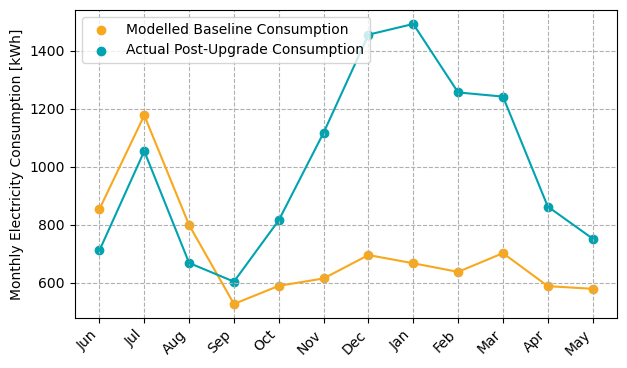

In [106]:
#Visualize modelled baseline vs. actual post-retrofit
plt.figure(figsize = (7,4))
plt.style.use('default')
plt.plot(PostRetrofitElec.index,PostRetrofitElec.modelled_kWh, color = step_gold)
plt.scatter(PostRetrofitElec.index,PostRetrofitElec.modelled_kWh, label = 'Modelled Baseline Consumption', color = step_gold)
plt.plot(PostRetrofitElec.index,PostRetrofitElec.kWh, color = step_blue)
plt.scatter(PostRetrofitElec.index,PostRetrofitElec.kWh, label = 'Actual Post-Upgrade Consumption', color = step_blue)
plt.grid(ls='--')
plt.ylabel('Bimonthly Gas Consumption [m$^{3}$]]')
plt.legend(loc = 'upper left')
#plt.ylim(0,600)
plt.ylabel('Monthly Electricity Consumption [kWh]')
plt.xticks(PostRetrofitElec.index, labels = PostRetrofitElec.month_, rotation=45, ha = 'right')  # Adjust the angle as needed

# 6 Utility Savings
Back to [Contents](#Contents)

In [107]:
# Actual post-retrofit gas consumption
post_gas = PostRetrofit.m3.sum()
post_gas

893

In [108]:
# Modelled baseline gas consumption - i.e. what it would've been without a heat pump
baseline_gas = PostRetrofit.modelled_m3.sum()
baseline_gas

1878.738735447058

In [109]:
# Actual post-retorfit electricity consumption
post_elec = PostRetrofitElec.kWh.sum()
post_elec

12029.155

In [110]:
# Baseline electricity consumption - i.e. what it would've been without a heat pump
baseline_elec = PostRetrofitElec.modelled_kWh.sum()
baseline_elec

8432.891450347332

In [111]:
# Gas Reduction
gas_savings = baseline_gas - post_gas
gas_savings

985.7387354470579

In [112]:
# Electricity increase
elec_inc = post_elec - baseline_elec
elec_inc

3596.263549652669

In [113]:
#To estimate monthly DHW can take intercept of baseline model 1.71 m3/day
DHW = 1.71*367
DHW


627.5699999999999

In [114]:
# Estimate fraction of heating done by ASHP
(1 - (post_gas - DHW)/(baseline_gas - DHW))*100

78.7854353709407

# 7 Estimated Seasonal COP
Back to [Contents](#Contents)

In [115]:
# To check that the gas savings and electricity increase make sense - want to make an estimate of the seasonal COP
# But first, I need to find the increase in electricity during the heating season (not impacted by the coolign savings)
# So I need to subtract the savings from June, July and September
temp_df = PostRetrofitElec.loc[PostRetrofitElec.month_.isin(['Jun','Jul','Aug'])]
temp_df

,From,To,kWh,days,HDDs,HDDs_day,CDDs,CDDs_day,modelled_kWh_day,modelled_kWh,month_
0,2022-06-03,2022-07-02,711.570,30,1.741667,0.058056,11.375000,0.379167,28.462303,853.869088,Jun
1,2022-07-03,2022-08-06,1053.751,35,0.000000,0.000000,20.208333,0.577381,33.622694,1176.794282,Jul
2,2022-08-07,2022-09-06,668.389,31,0.000000,0.000000,8.554167,0.275941,25.774881,799.021298,Aug


In [116]:
# Find elec savings
summer_elec_savings = (temp_df.modelled_kWh - temp_df.kWh).sum()
summer_elec_savings

395.97466788733766

In [117]:
heat_from_ASHP = gas_savings * 10.36 * 0.95 # the heat provided by the ASHP is estimated from the gas savings; units are kWh
ASHP_elec_heating = elec_inc + summer_elec_savings # estimated electricity used by ASHP for heating
SCOP = heat_from_ASHP/ASHP_elec_heating
SCOP

2.430125685297416

Looks the estimated SCOP is 2.4. The specs indicate a Region IV HSPF of 9 (SCOP of 2.6). The analysis was not equipped to precisely identify all factors impacting SCOP - there could be many potential explanations for differences. But the overall change in electricity is not unreasonable given change in gas consumption.

# 8 Cost Savings
Back to [Contents](#Contents)

Text(92.25, 0.5, 'Average Electricity Rate [$/kWh]')

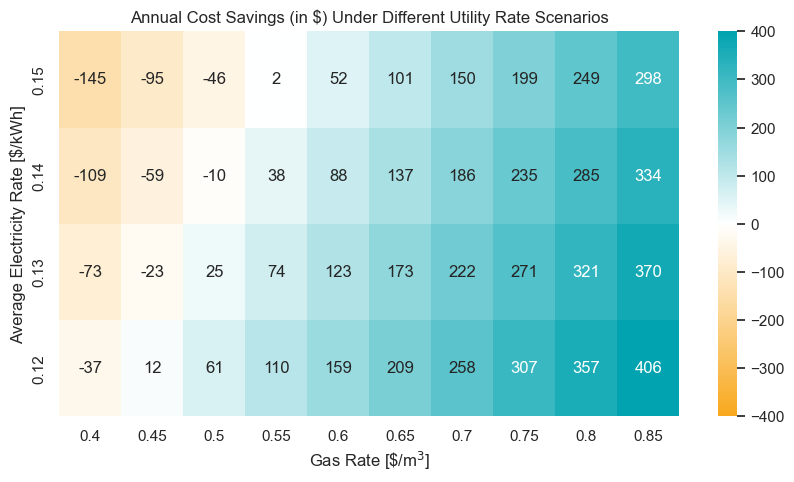

In [118]:
# Consider marginal Electricity Rate 0.12 to 0.15
elec_rates = np.arange(0.12,0.16,0.01)

# Consider marginal gas rates from 0.40 to 0.90
gas_rates = np.arange(0.40,0.90,0.05)

# Function to calc savings
def savings(gas_rate,elec_rate):
    savings = gas_savings * gas_rate - elec_inc*elec_rate 
    return round(savings,1)

# Run through different scenarios of gas and elec rates, and put results in a df
dic = {}

for gas_rate in gas_rates:
    col = []
    for elec_rate in elec_rates:
        col.append(int(savings(gas_rate,elec_rate)))
    dic[round(gas_rate,2)] = col
    
df = pd.DataFrame(dic)
df.index = [round(x,3) for x in elec_rates]
df = df.reindex([0.15,0.14,0.13,0.12])

# Plot a heat map showing the results
sns.set(rc={'figure.figsize':(10,5)})
sns.heatmap(df, cmap = custom_cmap, annot = True, vmin = -400,vmax=400, fmt = 'n')
plt.title('Annual Cost Savings (in $) Under Different Utility Rate Scenarios')
plt.xlabel('Gas Rate [\$/m$^{3}$]')
plt.ylabel('Average Electricity Rate [$/kWh]') 

In [119]:
# Gas rate April 2022 1st to Jul 1st 2022 - https://www.oeb.ca/sites/default/files/qram-egi-20220401.pdf
# Gas rate Jul 1st 2022 to Oct 1st 2022 - https://www.oeb.ca/sites/default/files/qram-egi-20220701-en.pdf
# Gas rate Oct 1st 2022 to Jan 1st 2023 - https://www.oeb.ca/sites/default/files/qram-egi-20221001-en.pdf
# Gas rate Jan 1st 2023 to April 1st 2023 -https://www.oeb.ca/sites/default/files/qram-egi-20230101-en.pdf
# Gas rate after April 2023 https://www.oeb.ca/sites/default/files/qram-egi-20230401-en.pdf
# Uncomment 22.60 in each cell below to do the sensitivity w.r.t. remaining carbon charge
# There is a very small difference in part of the gas rate (1 to 2 cents) depending on the level of gas consumption
# but I just did an average.

gas_apr2022 = 1.13*(18.3745 - 0.3623 + (11.299 + 10.6591 + 10.1573 + 9.7832)/4 + 0.0070 + 3.9258 + 9.79 + 0.0298 - 0.2204) # 22.61*1.13
gas_apr2022

47.4815265

In [120]:
gas_jul2022 = 1.13*(27.6752 - 0.3992 + (12.0380 + 11.3862 + 10.8758 + 10.4954)/4 + 0.0070 + 4.0765 + 9.79 + 0.1785) # 22.61*1.13
gas_jul2022

59.3553405

In [121]:
gas_oct2022 = 1.13*(27.6575 + 0.82 + (12.7984 + 12.1453 + 11.6339 + 11.2527)/4 + 0.0070 + 5.3075 + 9.79) # 22.61*1.13
gas_oct2022

62.75971974999999

In [122]:
gas_jan2023 = 1.13*(27.6575 + 1.948 + (12.8877 + 12.2031 + 11.6670 + 11.2674)/4 + 0.0070 + 5.0933 + 9.79 + 0.2101) # 22.61*1.13
gas_jan2023

64.084786

In [123]:
gas_apr2023 = 1.13*(13.2318 + 1.3295 + (12.0499 + 11.3754 + 10.8472 + 10.4535)/4 + 0.0079 + 4.2937 + 12.39 + 0.0487) # 22.61*1.13
gas_apr2023

48.00590299999999

In [124]:
# Function to map the right gas rate to the right row in the dataframe
def find_gas_rate(date):
    month = date.month
    year = date.year
    rate = 0
    if year  == 2022:
        if month in [4,5,6]:
            rate = gas_apr2022
        if month in [7,8,9]:
            rate = gas_jul2022
        if month in [10,11,12]:
            rate = gas_oct2022
    else:
        if month in [1,2,3]:
            rate = gas_jan2023
        if month in [4,5,6]:
            rate = gas_apr2023
            
    return(rate)

# Give it a try
find_gas_rate(datetime.datetime(2022, 9, 12, 14, 30, 0))        
    

59.3553405

In [125]:
# Add gas rates and savings to the post-retrofit dataframe
PostRetrofit['gas_rate'] = [find_gas_rate(x) for x in PostRetrofit.From]
PostRetrofit['gas_savings_dol'] = PostRetrofit.gas_rate/100 * (PostRetrofit.modelled_m3 - PostRetrofit.m3)
PostRetrofit

,From,To,Start Read,Start Read Type,End Read,End Read Type,m3,days,m3_day,HDDs,HDDs_day,CDDs,CDDs_day,modelled_m3_day,modelled_m3,start_month,end_month,gas_rate,gas_savings_dol
0,2022-06-03,2022-08-07,14332,A,14450,A,118,65,1.815385,1.741667,0.026795,34.341667,0.528333,2.023743,131.543264,Jun,Jul,47.481527,6.430549
1,2022-08-07,2022-10-06,14450,A,14545,A,95,60,1.583333,15.662500,0.261042,9.116667,0.151944,2.156256,129.375346,Aug,Sep,59.355340,20.403604
2,2022-10-06,2022-12-05,14545,A,14682,A,137,60,2.283333,349.770833,5.829514,0.000000,0.000000,5.306336,318.380179,Oct,Nov,62.759720,113.833692
3,2022-12-05,2023-02-03,14682,A,14875,A,193,60,3.216667,797.054167,13.284236,0.000000,0.000000,9.523467,571.408024,Dec,Jan,62.759720,237.487816
4,2023-02-03,2023-04-04,14875,A,15090,A,215,60,3.583333,709.729167,11.828819,0.000000,0.000000,8.700139,522.008338,Feb,Mar,64.084786,196.745636
5,2023-04-04,2023-06-05,15090,A,15225,A,135,62,2.177419,144.054167,2.323454,0.708333,0.011425,3.322961,206.023585,Apr,May,48.005903,34.095513


In [126]:
# Gas savings
gas_cost_savings = PostRetrofit.gas_savings_dol.sum()
gas_cost_savings

608.9968089686932

To find elec rates, used OEB bill calculator. Calculated two bills for 700 kWh and 800 kWh with the TOU breakdown provided in the accompanying case study. The marginal rate is the difference in cost between these two bills divided by 100 kWh.

![rates](Rates2.png)

In [127]:
# Value of new electricity that was consumed
elec_rate = (142.29-129.74)/100
elec_rate

0.12549999999999983

In [128]:
# Elec increase
elec_cost_increase = elec_inc * elec_rate
elec_cost_increase

451.33107548140936

In [129]:
net_savings = gas_cost_savings - elec_cost_increase
net_savings

157.6657334872839

In [130]:
summer_elec_savings * 0.126


49.892808153804545

# 9 Carbon Savings
Back to [Contents](#Contents)

In [131]:
# Gas EF
gas_EF = 1998 # g/m3

# Net carbon savings
carb_savings_AEF = gas_savings*gas_EF/1e6 - elec_inc*70/1e6 
carb_savings_AEF


1.7177675449475351

In [132]:
# Net carbon savings
carb_savings_AEF = gas_savings*gas_EF/1e6 - elec_inc*251/1e6 
carb_savings_AEF

1.066843842460402